In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,date
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re

In [21]:
data = pd.read_csv('dataset/data.csv', encoding='ISO-8859-1', delimiter=',')

In [22]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## limpeza e tratamento dos dados

###### Verificando missings em cada coluna

In [23]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

###### Removendo os registros que não tem CustomerId

In [24]:
data = data.dropna(subset=['CustomerID'])

In [25]:
data.shape

(406829, 8)

In [26]:
data.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

###### Coluna de Quantidade com valores negativos (minimo com discrepância)

In [27]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


###### Removendo os itens com quantidade negativa

In [28]:
data = data[data.Quantity > 0]

In [29]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


## Analise exploratória

Gráfico vendas por mês

Adicionando as colunas [mês,ano,faturamento]

In [30]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [57]:
data['InvoiceDate'].describe()

count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [47]:
data['invoice_month_name'] = data['InvoiceDate'].dt.month_name()

In [49]:
data['invoice_month'] = data['InvoiceDate'].dt.month

In [32]:
data['invoice_year'] = data['InvoiceDate'].dt.year

In [33]:
data['revenue'] = data['Quantity'] * data['UnitPrice']

In [50]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_month,invoice_year,revenue,invoice_month_name
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,15.30,December
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,20.34,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,22.00,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,20.34,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,20.34,December


###### Visualizando o somatório anual de vendas

<BarContainer object of 2 artists>

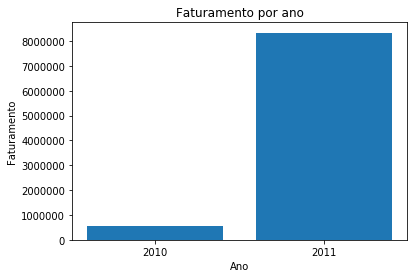

In [37]:
orders_year = data.groupby(by=['invoice_year'], as_index=False)['revenue'].sum()
plt.title('Faturamento por ano')
plt.xlabel('Ano')
plt.ylabel('Faturamento')
plt.bar(orders_year.invoice_year.astype(str), orders_year.revenue)

#fig = plt.gcf()
#fig.set_size_inches(13.5, 3.5)

###### Visualizando o somatório mensal de vendas

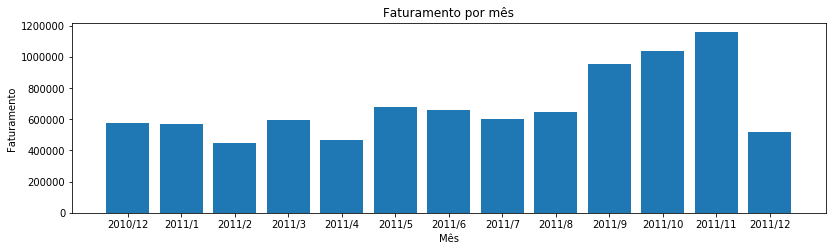

In [56]:
orders_month_year = data.groupby(by=['invoice_year', 'invoice_month'], as_index=False)['revenue'].sum()
orders_month_year['month_year'] = orders_month_year['invoice_year'].astype(str) + '/' + orders_month_year['invoice_month'].astype(str)
plt.title('Faturamento por mês')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.bar(orders_month_year.month_year, orders_month_year.revenue)

fig = plt.gcf()
fig.set_size_inches(13.5, 3.5)

### Separação das bases para predição do proximo dia de compra

Teremos dois dataframes, o dataframe histórico contendo as vendas anteriores a 01/09/2011 e o dataframe que representa o futuro, contendo as vendas posteriores a 01/09/2011

In [58]:
data_hist = data[(data.InvoiceDate < datetime(2011,9,1))].reset_index(drop=True)
data_next = data[(data.InvoiceDate >= datetime(2011,9,1))].reset_index(drop=True)

In [59]:
data_hist['InvoiceDate'].describe()

count                  226488
unique                  10767
top       2011-05-22 13:01:00
freq                      299
first     2010-12-01 08:26:00
last      2011-08-31 17:16:00
Name: InvoiceDate, dtype: object

In [60]:
data_next['InvoiceDate'].describe()

count                  171436
unique                   6519
top       2011-11-14 15:27:00
freq                      542
first     2011-09-01 08:25:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [61]:
data_clientes = pd.DataFrame(data_hist['CustomerID'].unique())
data_clientes.columns = ['CustomerID']

In [62]:
data_clientes.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


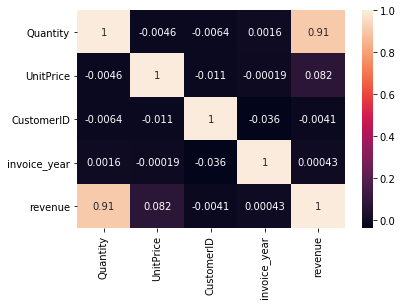

In [117]:
import seaborn as sb
sb.heatmap(data.corr(), annot = True)